# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data - Visualization + Rank swap

## 1. Visualization task

### 1a. Plot visulations 

In [63]:
import re
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

import math
import random

def currency_to_eur(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']] * 100)

def process_data(df):
    # Prepare card id and ip id for plotting
    
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Cleaning the data
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    unique_issuer_cc = df['issuercountrycode'].unique()
    unique_shopper_cc = df['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df['issuercountrycode'] = enc.transform(df.issuercountrycode)
    df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
    df['amount_eur'] = df.apply(lambda x: currency_to_eur(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df['txvariantcode'])
    df['txvariantcode'] = enc1.transform(df.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df['currencycode'])
    df['currencycode'] = enc2.transform(df.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df['shopperinteraction'])
    df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df['accountcode'])
    df['accountcode'] = enc4.transform(df.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df['cardverificationcodesupplied'])
    df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df[['issuercountrycode',
             'txvariantcode',
             'bin',
             'amount',
             'currencycode',
             'shoppercountrycode',
             'shopperinteraction',
             'cardverificationcodesupplied',
             'cvcresponsecode',
             'accountcode',
             'mail_id',
             'ip_id',
             'card_id',
             'amount_eur',
             'countries_equal']
    ]


In [ ]:
# process the dataset for visualization, then split into fraud and non_fraud
df = pd.read_csv("data/train_data.csv")
df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'
df.loc[df['txvariantcode'].isna(), 'txvariantcode'] = 'ZZ'
df['amount_eur'] = df.apply(lambda x: currency_to_eur(x), axis=1)

df_fraud = df[df['label'] == 1]
df_non_fraud = df[df['label'] == 0]

#### Card type with shopper country plots
Below, we plot the card variant and the shopper country code using sunburst plots.
As can be seen, the most popular card for fraudulent transactions is the mccredit, versus the
visadebit for the non-fraudulent ones. 
Moreover, most of the shoppers from the mccredit category are from Australia and Mexico in the fraud dataset,
whereas in the non-fraud dataset they are from Great Britain.
Therefore, we can conclude that both of these features can prove useful when discriminating between the classes.

In [58]:
from plotly.subplots import make_subplots
sp1 =px.sunburst(df_fraud, path=['txvariantcode', "shoppercountrycode"])
sp2 = px.sunburst(df_non_fraud, path=['txvariantcode', "shoppercountrycode"])

fig = make_subplots(rows=1, cols=2, specs=[
    [{"type": "sunburst"}, {"type": "sunburst"}]
])
fig.add_trace(sp1.data[0], row=1, col=1)
fig.add_trace(sp2.data[0], row=1, col=2)
fig.update_layout(height=500, width=800, title_text="Fraud Transactions (left) vs Non-Fraud Transactions (right)")
fig.show()

#### Transaction amount histogram

Below we plot the transaction amount converted in euro for each class.
It can be seen that the fraudulent transactions have more entries where the amount is higher than 100EUR, compared to non-fraud ones.

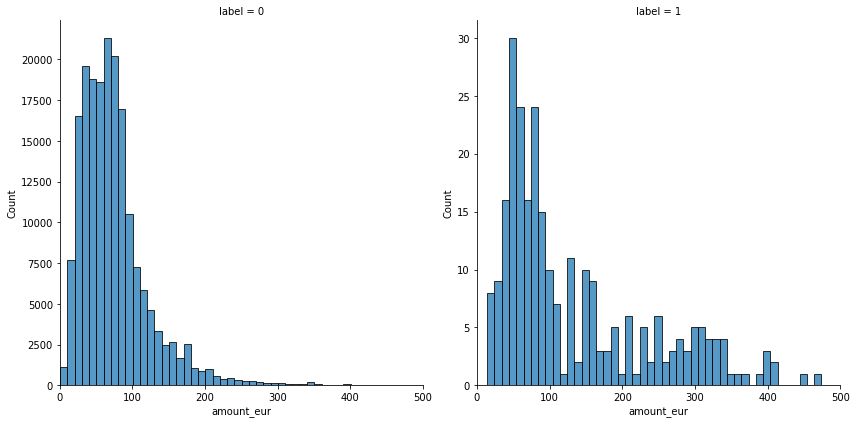

In [46]:
g = sns.FacetGrid(df, col='label', height=6, sharey=False)
g.set(xlim=(0, 500))
g.map_dataframe(sns.histplot, x="amount_eur", binwidth=10)

## Rank swap

In [61]:
def rank_swap(df: pd.DataFrame, columns: list[str], p: float):
    for column in columns:
        # sorted list for swapping
        sorted_list = np.sort(df[column].unique())
        sorted_len = len(sorted_list)
        swap_range = math.ceil(sorted_len * p)
        with np.nditer(df[column], op_flags=['readwrite']) as it:
            for val in it:
                # get index in sorted array
                ind = np.where(sorted_list == val)[0][0]
                # compute new index based on p value
                new_index = random.randrange(0 if swap_range > ind else ind - swap_range,
                                            sorted_len if ind + swap_range > sorted_len else ind + swap_range)
                val[...] = sorted_list[new_index]
    return df

In [65]:
df = pd.read_csv("data/train_data.csv")
X = process_data(df)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# rank swap only training data
X_rank_train = rank_swap(X_train, ['issuercountrycode', 'shoppercountrycode', 'card_id', 'mail_id', 'ip_id'], 0.5)
print(X_rank_train.head())

        issuercountrycode  txvariantcode       bin   amount  currencycode  \
185969                 49              8  462239.0  11050.0             0   
185602                 47              8  465943.0   9320.0             1   
176445                 32              8  475129.0  10500.0             1   
172649                120              8  475128.0   3395.0             1   
10685                  12              2  546097.0   6895.0             1   

        shoppercountrycode  shopperinteraction  cardverificationcodesupplied  \
185969                  37                   1                             1   
185602                  22                   1                             1   
176445                 104                   1                             1   
172649                  72                   1                             1   
10685                   37                   1                             1   

        cvcresponsecode  accountcode  mail_id   ip_id  c

In [66]:
def train_and_roc(X_train):
    # logistic regression
    logreg_classifier = LogisticRegression(random_state=0)
    logreg_classifier.fit(X_train, y_train)

    y_predictions = logreg_classifier.predict(X_test)
    y_predictions_proba = logreg_classifier.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

    y_score = logreg_classifier.decision_function(X_test)

    logreg_fpr, logreg_tpr, _ = roc_curve(y_test, y_predictions_proba)
    logreg_roc_auc = auc(logreg_fpr, logreg_tpr)


    # random forest
    forest_classifier = RandomForestClassifier(random_state=0)
    forest_classifier.fit(X_train, y_train)

    y_predictions = forest_classifier.predict(X_test)
    y_predictions_proba = forest_classifier.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

    forest_fpr, forest_tpr, _ = roc_curve(y_test, y_predictions_proba)
    forest_roc_auc = auc(forest_fpr, forest_tpr)

    # decision tree
    dtree_classifier = DecisionTreeClassifier(random_state=0)
    dtree_classifier.fit(X_train, y_train)

    y_predictions = dtree_classifier.predict(X_test)
    y_predictions_prob = dtree_classifier.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_predictions))
    print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

    dtree_fpr, dtree_tpr, _ = roc_curve(y_test, y_predictions_prob)
    dtree_roc_auc = auc(dtree_fpr, dtree_tpr)

    plt.figure(0).clf()
    plt.plot(logreg_fpr, logreg_tpr, label=f"Logistic regression (AUC = {logreg_roc_auc})")
    plt.plot(dtree_fpr, dtree_tpr, label=f"Decision tree (AUC = {dtree_roc_auc})")
    plt.plot(forest_fpr, forest_tpr, label=f"Random forest (AUC = {forest_roc_auc})")
    plt.legend()
    plt.show()

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84443389759005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       1.00      0.02      0.03        59

    accuracy                           1.00     37926
   macro avg       1.00      0.51      0.52     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84707061119022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.06      0.07      0.07        59

    accuracy                           1.00     37926
   macro avg       0.53      0.53      0.53     37926
weighted avg      

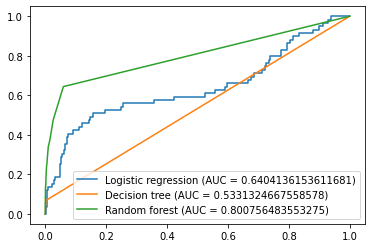

In [67]:
# train 3 classifiers and plot ROC curve, original data
train_and_roc(X_train)

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/ion/uni/q4/cda/cs4035-cda/jupyter/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.00      0.00      0.00        59

    accuracy                           1.00     37926
   macro avg       0.50      0.50      0.50     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84443389759005
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       1.00      0.02      0.03        59

    accuracy                           1.00     37926
   macro avg       1.00      0.51      0.52     37926
weighted avg       1.00      1.00      1.00     37926

Accuracy: 99.84707061119022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37867
           1       0.06      0.07      0.07        59

    accuracy                           1.00     37926
   macro avg       0.53      0.53      0.53     37926
weighted avg      

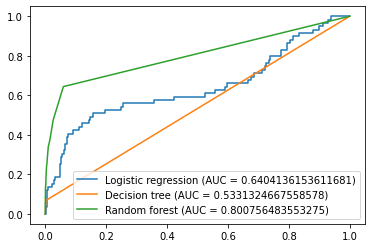

In [68]:
# train 3 classifiers and plot ROC curve, rank swapped training data

train_and_roc(X_rank_train)